In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../Style.mplstyle')
import pandas as pd
import os
import sys
import scipy
import matplotlib.dates as mdates
from datetime import datetime
sys.path.append('..')
from read_data_functions import *
from plot_functions import *
from calculations import *

In [2]:
parent_path = '../../../../'
path = 'L:/PG-Nanoteknologi/PROJEKTER/2024 Laura og Nan/'

# Screening
Screening_LCS = read_LCS_data(path + 'pilot kbh hovedbanegaard and noerregade/rawdata/particle/LCS/', parent_path, 'timestamp', 0, False)

# Brake wear data
Lund_LCS = read_LCS_data(path + 'Lund/LCS_vores/', parent_path, 'timestamp', 0, True)
Lund_OPS = read_OPS(path + 'Lund/', parent_path, 0)

# Field data
Field_LCS1 = read_LCS_data(path + 'cph central and nørreport measurements/Station 1/', parent_path, 'timestamp', 0, False)
Field_OPS1 = read_OPS(path + 'cph central and nørreport measurements/Station 1/OPS/', parent_path, 0)
Field_LCS2 = read_LCS_data(path + 'cph central and nørreport measurements/Station 2/', parent_path, 'timestamp', 0, False)
Field_OPS2 = read_OPS(path + 'cph central and nørreport measurements/Station 2/OPS/', parent_path, -1)

# Flip selected dataframes and change dataframe concentration keys
old_keys_DSB = ['SPS30_PN0.5', 'SPS30_PN1', 'SPS30_PN2.5', 'SPS30_PN4', 'SPS30_PN10']
old_keys_Lund_flip = ['PM5000S_2_PN0.3', 'PM5000S_2_PN0.5', 'PM5000S_2_PN1', 'PM5000S_2_PN2.5', 'PM5000S_2_PN5', 'PM5000S_2_PN10']
old_keys_Lund = ['PN0.5, #/cm3', 'PN1, #/cm3', 'PN2.5, #/cm3', 'PN4, #/cm3', 'PN10, #/cm3']

Screening_keys = ['2024-09-17 DG-0001A', '2024-09-19 DG-0001A', '2024-09-17 LCS0076', 
                  '2024-09-19 LCS0076', '2024-09-17 LCS0104', '2024-09-19 LCS0104']
Lund_keys = ['2024-10-15 DG-0049', '2024-10-16 DG-0049', '2024-10-17 DG-0049', '2024-10-15 DG-0051', '2024-10-16 DG-0051', 
             '2024-10-17 DG-0051', '2024-10-15 LCS109', '2024-10-16 LCS109', '2024-10-17 LCS109', '2024-10-15 DG-0072', 
             '2024-10-16 DG-0072', '2024-10-17 DG-0072', '2024-10-15 DG-0077', '2024-10-16 DG-0077', '2024-10-17 DG-0077']
Field1_keys = ['2024-12-09 DG-0158', '2024-12-10 DG-0158', '2024-12-11 DG-0158', '2024-12-12 DG-0158', 
               '2024-12-13 DG-0158', '2024-12-16 DG-0158', '2024-12-17 DG-0158']
Field2_keys = ['2024-12-09 DG-0159', '2024-12-10 DG-0159', '2024-12-11 DG-0159', '2024-12-12 DG-0159', 
               '2024-12-13 DG-0159', '2024-12-16 DG-0159', '2024-12-17 DG-0159']

Screening_flip = [False, False, False, False, False, False]
Lund_flip = [True, True, True, True, True, True, True, True, True, False, False, False, False, False, False]
Field_flip = [False, False, False, False, False, False, False]

Screening_LCS = LCS_bins(Screening_LCS, Screening_keys, None, Screening_flip, old_keys_DSB)
Lund_LCS = LCS_bins(Lund_LCS, Lund_keys, old_keys_Lund_flip, Lund_flip, old_keys_Lund)
Field_LCS1 = LCS_bins(Field_LCS1, Field1_keys, None, Field_flip, old_keys_DSB)
Field_LCS2 = LCS_bins(Field_LCS2, Field2_keys, None, Field_flip, old_keys_DSB)

# Merge dictionaries with data from train stations
DSB_LCS = merge_dicts(Screening_LCS, Field_LCS1, Field_LCS2)
DSB_OPS = merge_dicts(Field_OPS1, Field_OPS2)

c:\Users\B363580\Documents\GitHub\Master-thesis\calibration\..\read_data_functions.py:188: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df[time_label]).dt.date


In [3]:
DSB_keys_cal = ['2024-09-17 DG-0001A', '2024-09-17 LCS0076', '2024-09-17 LCS0104', 
                '2024-12-09 DG-0158', '2024-12-09 DG-0159',]
Lund_keys_cal = ['2024-10-15 DG-0049', '2024-10-15 DG-0051', '2024-10-15 LCS109', 
                 '2024-10-15 DG-0072', '2024-10-15 DG-0077']

In [4]:
for key in Lund_keys_cal:
    print(key)
    print(Lund_LCS[key]['Time'][0], Lund_LCS[key]['Time'][len(Lund_LCS[key]['PN<2.5'])-1])
    print(len(Lund_LCS[key]['PN<2.5']))


2024-10-15 DG-0049
2024-10-15 11:00:00 2024-10-15 23:59:00
776
2024-10-15 DG-0051
2024-10-15 11:04:00 2024-10-15 23:59:00
772
2024-10-15 LCS109
2024-10-15 07:00:00 2024-10-15 19:59:00
721
2024-10-15 DG-0072
2024-10-15 10:57:00 2024-10-15 16:59:00
362
2024-10-15 DG-0077
2024-10-15 10:57:00 2024-10-15 16:59:00
333


In [5]:
for key in DSB_keys_cal[1:]:
    print(key)
    print(DSB_LCS[key]['Time'][0], DSB_LCS[key]['Time'][len(DSB_LCS[key]['PN<2.5'])-1])
    print(len(DSB_LCS[key]['PN<2.5']))

for key in DSB_OPS.keys():
    if 'd1' in key:
        print(key)
        print(DSB_OPS[key]['Time'][0], DSB_OPS[key]['Time'][len(DSB_OPS[key]['PN2.5'])-1])
        print(len(DSB_OPS[key]['PN2.5']))

2024-09-17 LCS0076
2024-09-17 00:00:00 2024-09-17 23:59:00
1399
2024-09-17 LCS0104
2024-09-17 00:00:00 2024-09-17 23:59:00
1385
2024-12-09 DG-0158
2024-12-09 00:00:00 2024-12-09 16:57:00
986
2024-12-09 DG-0159
2024-12-09 09:12:00 2024-12-09 16:48:00
351
OPS1-CPH-d1
2024-12-09 10:56:14 2024-12-09 16:43:14
348
OPS1-NP-d1
2024-12-16 09:32:18 2024-12-16 15:45:18
374
OPS2-CPH-d1
2024-12-09 10:53:19 2024-12-09 16:41:19
349
OPS2-NP-d1
2024-12-16 09:48:06 2024-12-16 15:55:06
368


In [ ]:
def LCS_calibration_plot(plotz, figsize, sensor_dict, sensors, OPS_data, OPS_keys):
    fig = plt.figure(figsize)
    for i in range(plotz):
        for j in range(plotz-1):
            if (i>j):
                ax = plt.subplot2grid((plotz-1, plotz-1), (i-1,j))
                if j == 0:
                    ax.set(ylabel = sensors[i-2].split(' ')[1])
                if i == 6:
                    ax.set(xlabel = sensors[j-1].split(' ')[1])

                if j != i-1:
                    pass # Linear fits LCS vs LCS
                
                if i-1 == 5 and j < 5:
                    pass # Linear fits LCS vs OPS

                if i-1 and j == 5:
                    pass # OPS time series

                else:
                    pass # LCS time series

    return fig

0 0
1 0
1 1
2 0
2 1
2 2
3 0
3 1
3 2
3 3
4 0
4 1
4 2
4 3
4 4
5 0
5 1
5 2
5 3
5 4
5 5


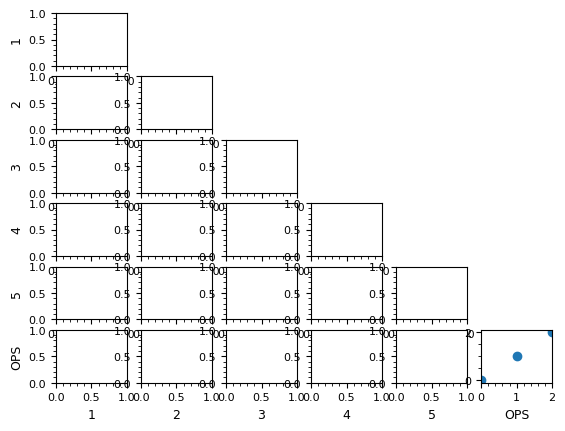

In [17]:
sensors = ['1', '2', '3', '4', '5', 'OPS']

plotz = 7
fig = plt.figure()
for i in range(plotz):
    for j in range(plotz-1):
        if (i>j):
            print(i-1, j)
            ax = plt.subplot2grid((plotz-1, plotz-1), (i-1,j))
            if j == 0:
                ax.set(ylabel = sensors[i-1])
            if i == 6:
                ax.set(xlabel = sensors[j])
            
            if i-1 and j == 5:
                ax.scatter([0, 1, 2], [0, 1, 2])